# SIXT33N Project
## Phase 6: Advanced Controls (and more!)

### EE16B: Designing Information Devices and Systems II, Spring 2021

Written by Vivek Athalye and Andrew Blatner (2017). Revised by Peter Schafhalter (2019). Revised by Hossein Najafi (2021).

## Table of Contents

* [Introduction](#intro)
* [Part 1: Analyzing a Turn](#part1)
* [Part 2: Implementing Turns](#part2)
* [Part 3: Correcting Mechanical Errors](#part3)
* [Part 4: Arduino Implementation of PCA Classify](#part4)

<a id='intro'></a>
## Introduction

This week, we will first implement port our PCA classifier from the iPython notebook to a file that can be run on the Arduino. This will allow us to integrate PCA with the rest of the project.

Then, we will revisit controls. Recall that our control scheme for SIXT33N modeled each wheel in the following way:

$$d_R[n+1] = d_R[n] + \theta_R u_R[n] - \beta_R$$

The open loop model has an input $u[n]$, corresponding to the PWM level, and outputs the distance for that wheel. We implemented a closed-loop controller by using the desired velocity and the difference between the wheel distances, $$\delta[n] = d_L[n] - d_R[n]$$

In this phase, we will implement turns by modifying the closed loop control scheme we developed to make SIXT33N move straight.

<a id='part1'></a>
## <span style="color:navy">Part 1: Analyzing a Turn</span>

### Materials
- SIXT33N Module in TinkerCAD
Model Link to be used in ths entire lab: [TinkerCAD Model](https://www.tinkercad.com/things/41tMTPoH7w7) 
- Closed-loop control scheme

### We want to turn with a specific radius.  What open-loop control input would lead to turning?  
During open-loop control, we sought to drive the car straight at our desired velocity $v^*$.  

We used our model of the car ($\theta$, $\beta$) to calculate the open-loop control input which drives the car straight in the absence of perturbations:  

$$u^{OL}_L = \frac{v^*+\beta_L}{\theta_L} $$
$$u^{OL}_R = \frac{v^*+\beta_R}{\theta_R} $$

Is it possible to calculate an open-loop control input which would result in turning with a desired radius?


### We have been turning during Closed-loop Control
We can get a clue about turning by considering how we did closed-loop control. We perform feedback control of SIXT33N in order to minimize the difference between the two wheels ($\delta[n] = d_L[n] - d_R[n]$). When perturbations cause one wheel to get ahead of the other resulting in non-zero $\delta$, feedback control turns the car to correct the error.  

Let's walk through this.  

Our feedback control policy is: 
$$u_L[n] = u_L^{OL} + \frac{k_L}{\theta_L}\delta[n]$$

$$u_R[n] = u_R^{OL} + \frac{k_R}{\theta_R}\delta[n]$$


Let's say the right wheel has moved further than the left ($d_R[n] > d_L[n]$), resulting in a negative $\delta[n]$. A negative $\delta[n]$ results in a reduction of $u_R[n]$, and an increase of $u_L[n]$. But what does this mean physically?

If the right wheel is getting ahead of the left one, the left wheel will need to move a little faster and the right wheel a little slower for the wheels to even back out. Thus, feedback control corrects errors by turning to compensate for them.  

So $\delta \ne 0$ can be used to turn the car. Let's get more precise.  


### Turning via reference tracking

We would like the car to turn with a specified radius $r$ and speed $v^*$. The controller's unit for distance is encoder ticks, but each tick is approximately 1 cm of wheel circumference.

To turn, we want $\delta$ to change at a particular rate. Without loss of generality, we'll analyze a right turn, corresponding to increasing $\delta$. For a left turn, we simply negate $\delta$. Our goal is to generate a reference from the desired $r$ and $v^*$ for the controller to follow. This reference will be a function of the controller's time-step.

Use the following variables:
- $n$ - time-step
- $r$ [cm] - turn radius of the center of the car; 1 cm ~ 1 encoder tick
- $d$ [ticks] - distance traveled by the center of the car
- $l$ [cm] - distance between the centers of the wheels; 1 cm ~ 1 encoder tick
- $\omega$ [rad/tick] - angular velocity
- $\theta$ [rad] - angle traveled

Inspect the following diagram:

<center>
<img width="400px" src="images/turning_figure.png">
</center>



From this geometry, can you write $\delta[n]$ in the following form?
$$\delta[n] = f(r,v^*,l,n)$$


Derive your answer here:


<span style="color:#075a04"> **1. What is the relationship between $\delta[n]$ and $v^*$ if $l$ and the turning radius $r$ are constant? <span style="color:#ba190f">**

< YOUR ANSWER ON GRADESCOPE >    

<span style="color:#075a04"> **2. How does $\delta[n]$ changes as a function of the number of time-steps ($n$) if the car is driving at a constant $v^*$ if $l$ and the turning radius $r$ are kept constant? <span style="color:#ba190f">**

< YOUR ANSWER ON GRADESCOPE >    

<span style="color:#075a04"> **3. If the car's speed doubles and its turning radius is also increased by 50%, how does the rate of $\delta[n]$ compare to before? Find the ratio of $\LARGE \frac{\delta_{new   }[n]}{\delta_{old   }[n]}$.<span style="color:#ba190f">**

< YOUR ANSWER ON GRADESCOPE >    

<a id='part2'></a>
## <span style="color:navy">Part 2: Implementing Turns</span>

### Materials
- TinkerCAD Module
- Closed-loop control scheme
- Plan from Task 1

### Sampling periods 
 
In our implementation, the control loop and the data collection have different periods, $T_c$ and $T_d$ respectively.  $T_d$ is an integer multiple of $T_c$: $m=\frac{T_d}{T_c} \in \mathbb{Z}^{+}$
 
The units of $v^*$ are [ticks/$T_d$] and the units of $n$ are [seconds/$T_c$]
 
We use $T_c=100$ms, $T_d=500ms$, so $m=5$.

**<span style='color:red'> Replace $v^*$ with $\frac{v^*}{m}$ [ticks/$T_c$]</span>**

### Implementation
- Open `turning.ino`.
- Copy the required code from `closed_loop.ino` into **`CODE BLOCK CON1/2/3`**
    - Copy the beta/theta values as well as the left and right jolt values.
    - you don't need to copy the k values and v_star as they will be specified explicitly in the checkoff questions.
    - Make sure to update pin numbers if you've made changes.
    - Setting `delta_ss` helps your car's driving converge to straight sooner!
- **Complete the function `delta_reference` in `CODE BLOCK CON4`, under `PREPROGRAMMED PATH`**.
    - Look at `CODE BLOCK CON0` to see how this is used!
    - Use the variables `TURN_RADIUS`, `v_star`, `CAR WIDTH`, and `n`.
    - `delta_ss` is used in `CODE BLOCK CON0`, so don't include it here.

When you're done, try it out! SIXT33N should go straight, turn left, go straight, and turn right. To show how the car moves in TinkerCAD, observe the two waveforms being plotted in the serial plotter. The blue curve corresponds to the x-position of the car, and the orange line corresponds to the y-position of the car. The trajectory being represented is the shape below. The x and y positions of this trajectory are also shown over time. You should observe a similar trajectory in the serial plotter in TinkerCAD.

In the Serial plotter, the BLUE line corresponds to the X position of the car and the yellow line to the Y position of the car.

<img width=700px src="images/car.png">
<img width=700px src="images/car2.png">

<span style="color:#075a04"> **4. If the car's speed $v^*$ is set to be $201.759$, and both $k_{left}$ and $k_{right}$ are set to 0.2, what is the final value of X position of the car? The coordinates being printed in the serial plotter are formatted as (X position, Y position).<span style="color:#ba190f">**

< YOUR ANSWER ON GRADESCOPE >    

<span style="color:#075a04"> **5. In the same case for Q4, what is the final value of Y position of the car.<span style="color:#ba190f">**

< YOUR ANSWER ON GRADESCOPE >    

<span style="color:#075a04"> **6. Change the length of the 3rd command from 8000 to 4000. You can do so by changing the line `int run_times[NUM_COMMANDS] = {8000, 12600, 8000, 12600};` to `int run_times[NUM_COMMANDS] = {8000, 12600, 4000, 12600};`. If the car's speed $v^*$ is set to be $201.759$, and both $k_{left}$ and $k_{right}$ are set to 0.2, what is the final value of the X position of the car.<span style="color:#ba190f">**

< YOUR ANSWER ON GRADESCOPE >    

<span style="color:#075a04"> **7. In the same case as Q6, what is the final value of the Y position of the car? <span style="color:#ba190f">**

< YOUR ANSWER ON GRADESCOPE >    

<span style="color:#075a04"> **8. Change the length of the 2nd and 4th command from 12600 to 25200. You can do so by changing the line `int run_times[NUM_COMMANDS] = {8000, 12600, 8000, 12600};` to `int run_times[NUM_COMMANDS] = {8000, 25200, 8000, 25200};`. If the car's speed $v^*$ is set to be $201.759$, and both $k_{left}$ and $k_{right}$ are set to 0.2, what do you observe in the trajectory of the car? Which of the following applies to the trajectory the car is taking?<span style="color:#ba190f">**

< YOUR ANSWER ON GRADESCOPE >    

<span style="color:#075a04"> **9. In Q8, what is the final value of the X position of the car?<span style="color:#ba190f">**

< YOUR ANSWER ON GRADESCOPE >    

<span style="color:#075a04"> **10. In Q8, what is the final value of the Y position of the car?<span style="color:#ba190f">**

< YOUR ANSWER ON GRADESCOPE >    

<a id='part4'></a>
## <span style="color:navy">Part 3: Recording Your Test Word</span>


### Materials
- Microphone


This section will walk you through implementing your classification algorithm on the Arduino. In addition, you will need to transfer the PCA vectors and mean to the microcontroller. Re-visit your PCA lab Jupyter notebook and use the next few lines to print and format your PCA vectors to have them ready to be copied into the TinkerCAD environment and initialize the PCA vector variables on the microcontroller. You should copy and paste the following lines in the appropriate place in your PCA Jupyter notebook (right after you did SVD) and initialize the variable `pca_num` properly to print the first and then the second PCA vector. The following code for instance prints the first PCA vector, assuming `Vt` is  the `Vt` of the SVD decomposition during PCA:

In [ ]:
a = '={'
v = Vt
pca_num = 0

for i in v[pca_num,:].T:    # change pca_num to print the corresponding vector
    a += str(float(int(i*10000))/10000) + ', '
a = a[:-2]+"};"
print("PCA vector")
print(a)

<a id='part2'></a>
**Use the next section to record your own test word (only one word, not 30 words like before!) and process it using the following code. The last part of the code formats the audio vector ready to be copied and pasted in TinkerCAD to initialize the relevant variable (`result`). You will need it for Part 5.**


you are going to **record your own `wav` files with one of the four words you chose in PCA".** 

"Good" Audio data has a high signal to noise ratio. Recording words while far away from the microphone may cause your intended word to blend in with background noise. However "oversaturation" of the audio signal (speaking too loudly and/or too closely into the mic) will distort the signal. 

To record your own `wav` files, we suggest you use the [online recorder](https://online-voice-recorder.com). 

**For each chosen word, do the following:**
1. Click on record button on the webpage, and come back to this page. 
2. **Run the following script, when you see the numbers 1 appear, say the word you want to record.**
    - The recording window is 2 second. You want to finish the word in this period.
    - **Pronounce the word as you did in the PCA lab.** This will result in better classification.
    
    
3. Once you've recorded the word, the script will stop automatically. **Then go back the  webpage and stop the recording.** Your window should appear like the following:

<center>
<img width="800px" src="images/recording.png">
</center>

4. Change the start time to be near your sample and near the end time. **You want to remove the noise singnals before and after the sample.** The total recording time should be around 2 seconds.

5. When you save the file, it is the `mp3` type. Use the [audio converter](https://online-audio-converter.com) to convert it to `wav` file with the options shown as below.

<center>
<img width="600px" src="images/convert_to_wav.png">
</center>

6. Change the file path in section 1.1 of the `read_wav` function and re-run the whole procedure again. Tweak `length`, `pre_length` and `threshold` to make sure they are aligned and distinguishable in time waveforms.

If you cannot get access to the website, you can record with your phone. However, you'll need to convert your recording to a `wav` file. You also need to clip it to remove the noise signals before the first sample and after the last sample. Another website to convert the audio files are [Audio Converter](https://www.freeconvert.com/audio-converter) and a website to trim the `wav` file is [mp3cutter](https://www.mp3cutter.com). You may also find other useful websites to do this.

The following code will allow you to time two seconds to record your word:


In [1]:
import utils
counts = 1 # number of words to record
record_time = 2   # record time for each sample of the word

utils.recording_timer(counts, record_time)

Start recording ...
1
Recording is done.


Make sure to replace `word_raw_test` with your own word below.

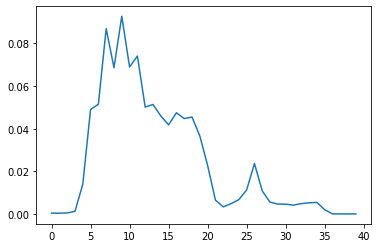

={0.0005, 0.0004, 0.0006, 0.0013, 0.0139, 0.0489, 0.0513, 0.0867, 0.0684, 0.0925, 0.0687, 0.0739, 0.05, 0.0513, 0.0459, 0.0417, 0.0474, 0.0447, 0.0454, 0.0366, 0.0227, 0.0066, 0.0034, 0.0049, 0.0068, 0.0113, 0.0237, 0.0108, 0.0056, 0.0047, 0.0047, 0.0042, 0.0049, 0.0053, 0.0055, 0.0021, 0.0001, 0.0001, 0.0001, 0.0001};


<Figure size 432x288 with 0 Axes>

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import csv
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def get_snippets(data, length, pre_length, threshold):
    """Attempts to align audio samples in data.
    
    Args:
        data (np.ndarray): Matrix where each row corresponds to a recording's audio samples.
        length (int): The length of each aligned audio snippet.
        pre_length (int): The number of samples to include before the threshold is first crossed.
        threshold (float): Used to find the start of the speech command. The speech command begins where the
            magnitude of the audio sample is greater than (threshold * max(samples)).
    
    Returns:
        Matrix of aligned recordings.
    """
    assert isinstance(data, np.ndarray) and len(data.shape) == 2, "'data' must be a 2D matrix"
    assert isinstance(length, int) and length > 0, "'length' of snippet must be an integer greater than 0"
    assert 0 <= threshold <= 1, "'threshold' must be between 0 and 1"
    snippets = []

    # Iterate over the rows in data
    for recording in data:
        # Find the threshold
        recording_threshold = threshold * np.max(recording)

        # Figure out when interesting snippet starts
        i = pre_length
        while recording[i] < recording_threshold:
            i += 1
            
        snippet_start = min(i - pre_length, len(recording) - length)
        snippet = recording[snippet_start:snippet_start + length]

        # Normalization
        snippet = snippet / np.sum(snippet)
        
        snippets.append(snippet)

    return np.vstack(snippets)


# Load data from wav
word_raw_test = utils.read_wav("test_word/test_word.wav", counts)


# Get snippets
length = 40      # Default: 40     # Keep for example wav files, adjust this with your recordings
pre_length = 5   # Default: 5      # Keep for example wav files, adjust this with your recordings
threshold = 0.5  # Default:  0.5   # Keep for example wav files, adjust this with your recordings

word_processed_test = get_snippets(word_raw_test, length, pre_length, threshold)
plt.plot(word_processed_test.T)
plt.show()
plt.figure()

a = '={'
v = word_processed_test[0,:]


for i in v.T:
    a += str(float(int(i*10000))/10000) + ', '
a = a[:-2]+"};"
print(a)

##### <a id='part4'></a>
## <span style="color:navy">Part 4: Arduino Implementation of PCA Classifier</span>


### Materials
- Recorded word
- TinkerCAD Model


Your last step will be to implement your <b>data processing</b> and <b>classification</b> (just the projection, not the PCA) in the Arduino sketch <b>`classify.ino`</b>. Since the Arduino environment does not have as many in-built functions as Python, you might have to write out the functions yourself. For example, a dot product should be written as:

`float result = 0;`<br/>
`for (i=0; i<LENGTH; i++){`<br/>
&emsp; `result += vector1[i]*vector2[i];`<br/>
`}`

For debugging purposes, printing to the serial plotter looks like the line below.

<code>Serial.println("I'm being printed!");</code>

There are 3 code blocks (`PCA1/2/3`) that you need to modify. <b>You should not have to change anything else outside these marked code blocks.</b> 

**`CODE BLOCK PCA1`**
- Copy `SNIPPET_SIZE`, `PRELENGTH` and `THRESHOLD` from the PCA/SVD Ipython notebook.
- Read the following to set `KMEANS_THRESHOLD` and `LOUDNESS_THRESHOLD`.

**`KMEANS_THRESHOLD` filters the classification depending on a sample's distance from the closest centroid.** If the L2 norm (distance) is larger than the threshold, your classification algorithm should simply ignore it and wait for the next sample. Look at the plot of sample data and the centroids from the PCA Notebook and approximate a radius around the centroids that capture most of the data. **Try to be conservative - it's better to not classify than to misclassify.**

**`LOUDNESS_THRESHOLD` filters the classification depending on the amplitude of the recorded data.** If the recorded data is too soft, we do not want to classify it as it is probably noise. Since the loudness unit is arbitrary, start by using `700`. Later, if the Arduino classifies noise, increase this constant. If it misses a lot of speech (i.e. thinks your word is noise), decrease this constant. This variable is used internally in the enveloping function.

**`CODE BLOCK PCA2`**
- Copy the PCA vectors, mean, and centroids from the PCA/SVD Ipython Notebook.
- If you need more than 2 principal components, add a new `pca_vec3` array. 
- Using more principal components increases the dimensionality of the centroids and projections.

**`CODE BLOCK PCA3`**
- This is the actual classification algorithm.
- Initialize the variable `result` with the processed audio of your word of choice, or use one of the samples already included in the code.
- Project this data onto your new PCA basis.
    - Remember to subtract the mean vector, before doing a dot product for each basis.
    - Use the variables `proj1` and `proj2` to store the projection results.
- Classify the projections using the centroids.
    - Find the distance between the projected data point and each centroid using the function `l2_norm` (for 2 principal components) or `l2_norm3` (for 3 principal components). Look up the function definition in the sketch.
    - Out of the 4 centroids, find the one with the smallest L2 norm.
    - Verify this distance is less than `KMEANS_THRESHOLD`.
- Print the classification to the serial monitor.

Now upload the sketch, open the serial monitor, and run. And observe how the Arduino classifies your word.

**<span style="color:red">If the Arduino does not classify as well as you think it should, remember to play with the `KMEANS_THRESHOLD` and `LOUDNESS_THRESHOLD` variables.</span>** To debug the sketch, you can also print out any of the variables you have used. 

Voila! Your SIXT33N can recognize your words!

**<span style="color:red">Summary TO DO</span>** 
- **<span style="color:red">Fill in `CODE BLOCK PCA1`: Fill out `SNIPPET_SIZE`, `PRELENGTH`, `THRESHOLD`, `KMEANS_THRESHOLD` and `LOUDNESS_THRESHOLD`</span>** 
- **<span style="color:red">Fill in `CODE BLOCK PCA2`: Copy the principal components, mean vector and centroids from the IPython notebook</span>**
- **<span style="color:red">Fill in `CODE BLOCK PCA3`: Do the actual classification.</span>**

**Try all 4 words as your test word and make sure you are able to get enough accuracy on the Arduino when classifying those words.**